# Exploration of Car Make and Violation Description Data from The City of Los Angeles Parking Citation Open Dataset

Based on [previous explorations](https://github.com/hackforla/lucky-parking/tree/citation-analysis/notebooks/exploratory) of the Los Angeles Parking Citation Open Dataset, it was found that parking citation violation types varied greatly by car make. This exploration will repeat that analysis and look at picking the best features for a model for users to interact with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
from pathlib import Path
import random
import seaborn as sns

# Load project directory
PROJECT_DIR = Path(os.path.abspath('../..'))

In [2]:
# Load already cleaned data from makefile command
# 20% sampled from raw dataset
# Only make and violation_description columns
df = pd.read_csv(PROJECT_DIR / 'data' / 'processed' / '2021-01-02_processed_02samp.csv', index_col=0)
df.head()

,make,violation_description
index,,
0,Mazda,PARK IN GRID LOCK ZN
1,Mercedes Benz,PREF PARKING
2,Nissan,PREF PARKING
3,Chevrolet,NO STOP/STAND PM
4,Ford,DSPLYPLATE A


In [3]:
# Examine missing data
df.isna().sum()/len(df)*100

make                     0.190180
violation_description    0.425833
dtype: float64

In [4]:
# Drop all missing data
df.dropna(inplace=True)

In [5]:
# Create table of violation ratio by make
make_vio_dict = {}
for make in df.make.value_counts().head(40).index:
  counts = df.loc[(df.make == make), 'violation_description'].value_counts()
  count_ratio = counts/counts.sum()
  make_vio_dict[make] = count_ratio.to_dict()
make_ratio = pd.DataFrame.from_dict(make_vio_dict).T.fillna(0)

In [6]:
# Show table of violation ratios
make_ratio.head(10).style.background_gradient(cmap='Blues').format("{:.3f}")

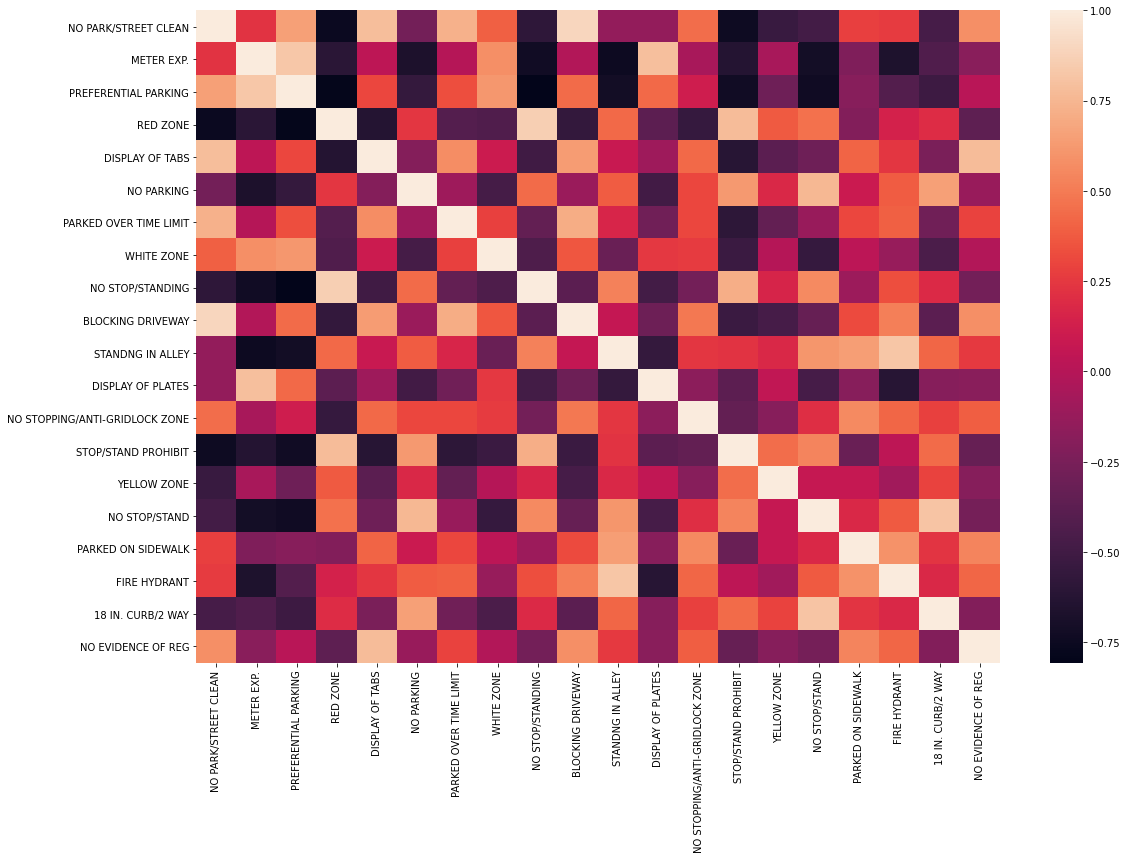

In [7]:
# Correlation heat map
plt.figure(figsize=(18,12))
sns.heatmap(make_ratio.iloc[:,:20].corr())
plt.show()

In the heat correlation map, light colors indicate high positive correlation and dark colors indicate high negative correlation. One of the things that jump out the most are the dark bands caused by red zone, stop/stand prohibit, and no stop/stand. That indicates that car makes that get a lot of red zone tickets will have lower relative amount of street cleaning, meter expiration, and preferential parking tickets. To further explore this relationship, principal component analysis can be done to see if there are natural axes of behavior contained in the data.

In [9]:
# Find principal component of violation ratio data using one component
pca = PCA(n_components=4)
make_pca = pd.DataFrame(data = pca.fit_transform(make_ratio)
             , columns = [f'Principal_Component_{n + 1}' for n in range(len(pca.components_))], index = make_ratio.index)
make_pca.head()

,Principal_Component_1,Principal_Component_2,Principal_Component_3,Principal_Component_4
Toyota,-0.055672,-0.041745,-0.013679,-0.018573
Honda,-0.054841,-0.051727,-0.011911,-0.008328
Ford,-0.022765,-0.048979,0.003009,0.004584
Nissan,-0.027248,-0.042475,-0.012727,-0.009084
Chevrolet,-0.011146,-0.043455,-0.001761,0.007613


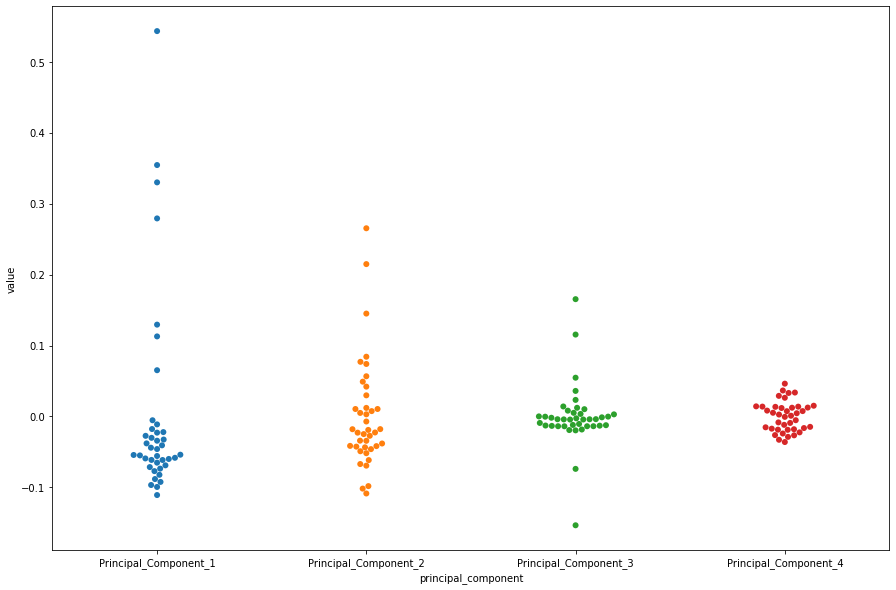

In [11]:
plt.figure(figsize=(15,10))
sns.swarmplot(x='principal_component' , y='value', data=pd.melt(make_pca.reset_index(), id_vars=['index'], var_name='principal_component'), size=6)
plt.show()

[]

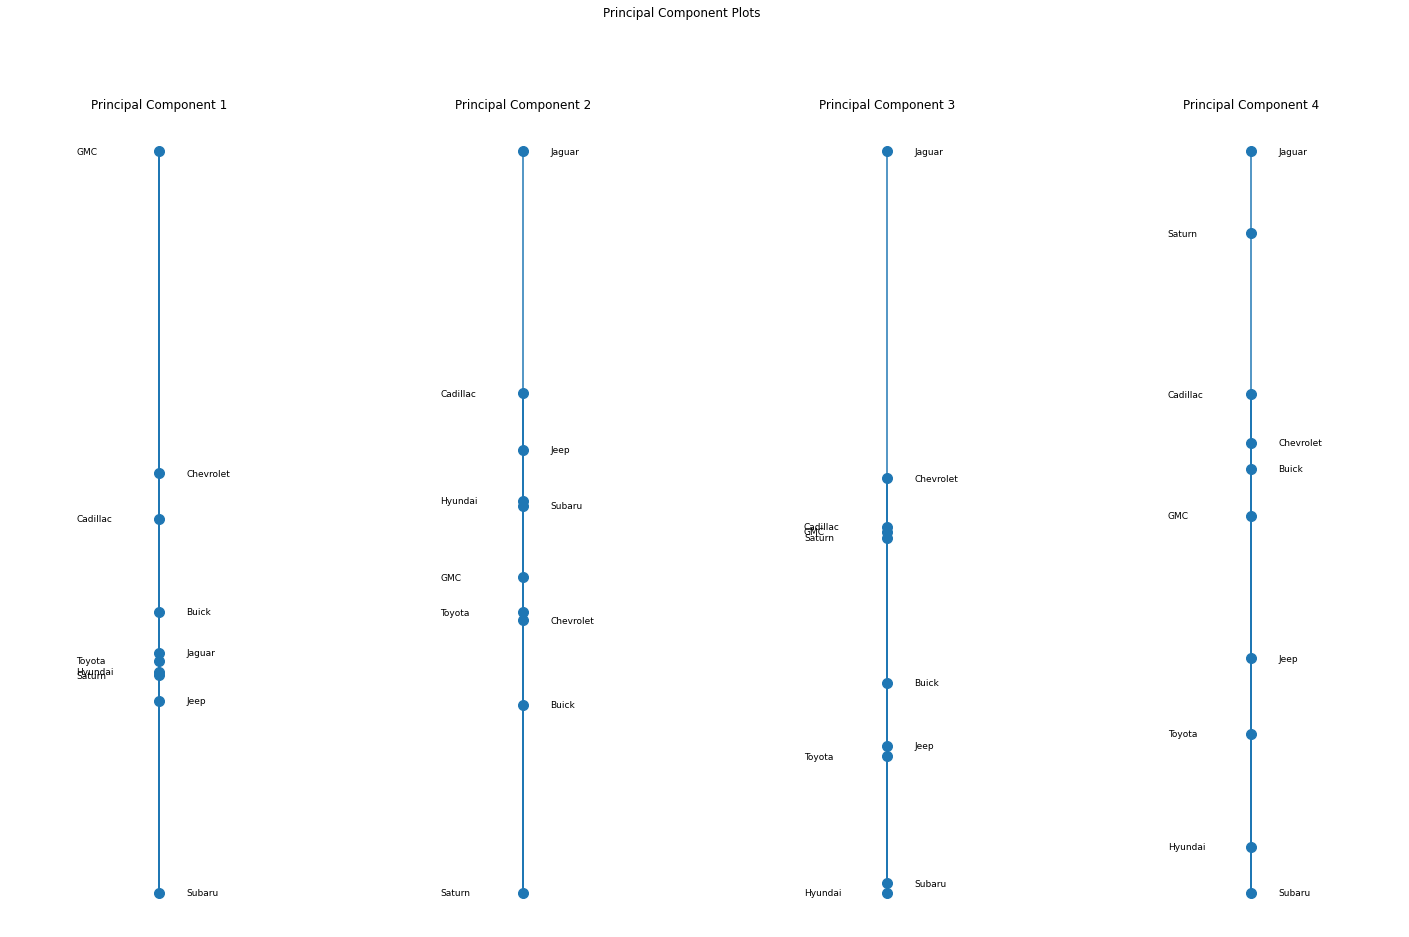

In [10]:
# Plot each make on each principal component
fig, axes = plt.subplots(1, len(pca.components_), figsize=(25,15))
fig.suptitle('Principal Component Plots')

for ind, ax in enumerate(axes):
    subset = make_pca.iloc[::4, ind]
    # Add line return to Mercedes Benz
    subset.rename(index={'Mercedes Benz': 'Mercedes\nBenz'}, inplace=True)
    ax.plot(np.zeros(len(subset)), subset, marker='.', markersize=20)
    ax.axis('off')
    ax.set_title(f'Principal Component {ind+1}')
    for i, txt in enumerate(subset.index):
        if i%2 == 0:
            ax.annotate(txt, (-0.03, subset.iloc[i]), fontsize=9, va='center')
        else: 
            ax.annotate(txt, (0.01, subset.iloc[i]), fontsize=9, va='center')

plt.plot()

In [12]:
# Print explained variance ratio
pca.explained_variance_ratio_

array([0.68955474, 0.20879154, 0.07044106, 0.01533257])

In [23]:
# Examine principal component weights
pca_components = pd.DataFrame(pca.components_, columns=make_ratio.columns, index=[f'PC_{n + 1}' for n in range(len(pca.components_))])
pca_components.style.background_gradient(cmap='Blues').format("{:.3f}")

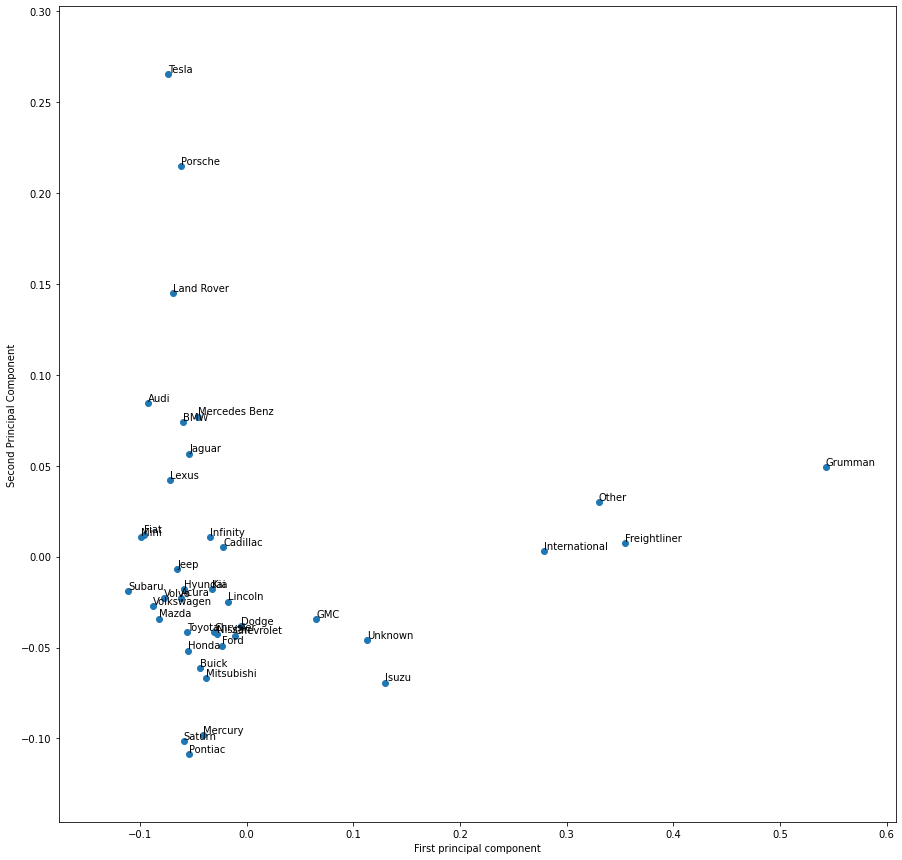

In [24]:
# PCA 2-component plot
plt.figure(figsize=(15,15))
plt.scatter(make_pca.iloc[:,0],make_pca.iloc[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.margins(0.1)
for i, txt in enumerate(make_pca.index):
    plt.annotate(txt, (make_pca.iloc[i,0], make_pca.iloc[i,1]), fontsize=10, va='bottom')
plt.show()

In [25]:
# Breakdown of the highest violation weight in each principal component
pd.DataFrame({'Major Violation Component': pca_components.apply(lambda x: x.idxmax(), axis=1).to_list() ,'Weight Fraction': pca_components.max(axis=1)})

,Major Violation Component,Weight Fraction
PC_1,RED ZONE,0.706810
PC_2,METER EXP.,0.685941
PC_3,COMM VEH OVER TIME LIMIT,0.572388
PC_4,DISPLAY OF PLATES,0.626753



If we were to build a model with the fewest amount of features, instead of just picking the highest weights we would pick the highest absolute value weights and throw out any other weights that are close to zero. Each principal component reflects real life spectrums of human behavior. The first positive and negative weights are often the best clues to understanding what each principal component is made up of.

In [26]:
pca_components.loc['PC_1'].sort_values(ascending=False, key=abs)[:10]

RED ZONE                    0.706810
NO PARK/STREET CLEAN       -0.523965
METER EXP.                 -0.350361
PREFERENTIAL PARKING       -0.171379
DOUBLE PARKING              0.137312
COMM VEH OVER TIME LIMIT    0.135800
DISPLAY OF PLATES          -0.092032
DISPLAY OF TABS            -0.087879
STOP/STAND PROHIBIT         0.083552
18 IN/CURB/COMM VEH         0.064633
Name: PC_1, dtype: float64

The principal components are ordered by highest variance, which makes data points on the opposite sides of this scale the easiest to differentiate via their parking behavior. In the 2D plot above, it can be seen that the Suburu and the Grumman are on opposite sides of the first principal component. According to the listed component weights, the Grumman, has a very high number of red zone parking tickets and very few street cleaning tickets, and vice versa for the Suburu. Since the most popular Grumman vehicle is a US Postal Service truck and California enforces its parking laws even on the USPS, this is very much possible. Looking at the 2D plot, it becomes very obvious that this principal component separates out passenger vehicle citations from the commercial vehicle citations.

In [27]:
# Sort of components of second component by absolute value
pca_components.loc['PC_2'].sort_values(ascending=False, key=abs)[:10]

METER EXP.                0.685941
NO PARK/STREET CLEAN     -0.575693
DISPLAY OF PLATES         0.393721
DISPLAY OF TABS          -0.126309
PREFERENTIAL PARKING      0.093333
NO PARKING               -0.063482
PARKED OVER TIME LIMIT   -0.057472
EXCEED 72HRS-ST          -0.048067
NO EVIDENCE OF REG       -0.043495
BLOCKING DRIVEWAY        -0.038432
Name: PC_2, dtype: float64

Here we can see that principal component 2 has its main component being meter expiration but street cleaning violations are negatively correlated, meaning car makes that score higher along this axis have less street sweeping and more meter expiration and display of plate violations. Also, the top offender is Tesla, followed by other luxury brand car makes and ends with some more affordable domestic car makes. This could reflect the parking behavior of people who drive luxury cars vs more affordable cars--people who drive luxury cars are more likely to park their car off the public streets, either because they have a garage or live somewhere with allocated parking.


In [38]:
pca_components.loc['PC_3'].sort_values(ascending=False, key=abs)[:10]

RED ZONE                   -0.595246
COMM VEH OVER TIME LIMIT    0.572388
NO PARK/STREET CLEAN       -0.363988
METER EXP.                 -0.288659
NO PARKING                  0.181854
PREFERENTIAL PARKING       -0.126969
COMM TRAILER/22 FT.         0.100475
DOUBLE PARKING              0.081516
18 IN/CURB/COMM VEH         0.075402
18 IN. CURB/2 WAY           0.072698
Name: PC_3, dtype: float64

What we find in PCA_3 is the inclusion of a lot of commercial vehicle specific citations. In contrast to the first principal component which also addressed commercial vehicles, there is an inverse relationship between red zone citations and commercial vehicle over time limit citations. There are other positive weights regarding citations for not parking near the curb at all. This particular component might be differentiating between commercial vehicles that park at the curb to do deliveries and commercial vehicles that unload a lot of material over long periods of time, like moving trucks that perhaps park in the middle of the street

In [39]:
pca_components.loc['PC_4'].sort_values(ascending=False, key=abs)[:10]

DISPLAY OF PLATES           0.626753
PREFERENTIAL PARKING       -0.402764
DISPLAY OF TABS             0.335876
COMM VEH OVER TIME LIMIT   -0.325645
METER EXP.                 -0.291338
EXCEED 72HRS-ST             0.212993
STOP/STAND PROHIBIT        -0.152673
NO EVIDENCE OF REG          0.129390
DOUBLE PARKING             -0.123752
NO PARKING                 -0.103637
Name: PC_4, dtype: float64

In the fourth principal component the positive weights have to deal with display of plates and tabs and the negative weights have to do with parking. In the 2D graph, there doesn't seem to be a specific luxury car vs non-luxury car make grouping here as both Porsche and Pontiac are both bad offenders. One interpretation is that this component shows the people who drives either Porsches and Pontiacs to either not display up to date plates or tags due to privacy reasons or economic reasons. It is such a common phenomenon for people not to display plates for privacy reasons, which people usually do by leaving the temporary dealer plates on forever, that the state of Caliornia recently had to change the law banning it and requiring temporary, paper license plates.

Based on what was observed in the breakdown of the top 4 principal components, it would be useful to plot the two passenger car related components against each other and the two commercial vehicle related components together.

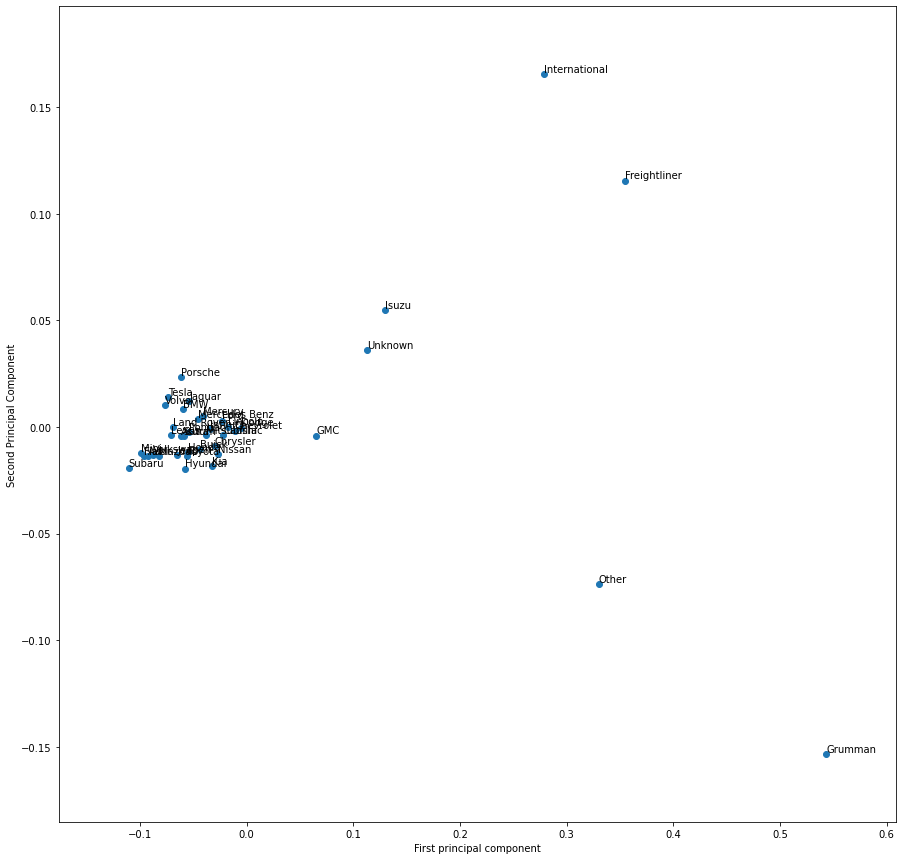

In [35]:
# PCA 2-component plot
plt.figure(figsize=(15,15))
plt.scatter(make_pca.iloc[:,0],make_pca.iloc[:,2])
plt.xlabel('First principal component')
plt.ylabel('Third Principal Component')
plt.margins(0.1)
for i, txt in enumerate(make_pca.index):
    plt.annotate(txt, (make_pca.iloc[i,0], make_pca.iloc[i,2]), fontsize=10, va='bottom')
plt.show()

By plotting the two commercial vehicle related principal components against each other, we find that the passenger cars are all clumped together whereas the commercial makes are spread out. At the top are larger commercial trucks and at the bottom right are US Postal Service vehicles.

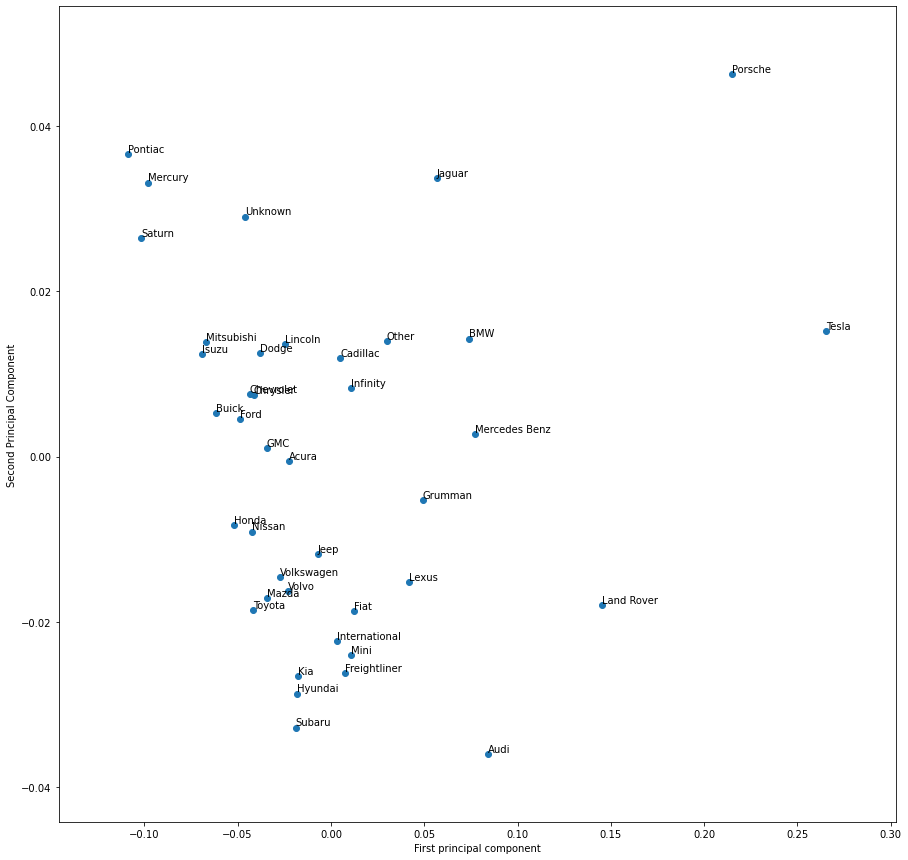

In [31]:
# PCA 2-component plot
plt.figure(figsize=(15,15))
plt.scatter(make_pca.iloc[:,1],make_pca.iloc[:,3])
plt.xlabel('Second principal component')
plt.ylabel('Fourth Principal Component')
plt.margins(0.1)
for i, txt in enumerate(make_pca.index):
    plt.annotate(txt, (make_pca.iloc[i,1], make_pca.iloc[i,3]), fontsize=10, va='bottom')
plt.show()

Plotting the second and fourth principal components gives a very nice dispersion of all the car makes. At the top there seems to be a divide between Pontiac, Mercury, Jaguar, Saturn, and Porsche vs the rest. At the right there seems to be a divide between Porsche and Tesla and the rest. As we approach the top right, car makes tend to have less street sweeping tickets and more tickets that are associated with luxury cars. At the top left, there are cars that get more street sweeping tickets and unregistered plates/tabs, which might indicate these cars being abandoned.